In [118]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from glob import glob
import pandas as pd
from skimage import img_as_float
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.measure import find_contours
from skimage.segmentation import watershed
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte

### ABCF 이미지 로드

In [57]:
def show_image(image, title='Image'):
    if image is not None:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()

In [58]:
def show_image_new(image, title='Image'):
    # 이미지를 uint8 형식으로 변환
    image_uint8 = (image * 255).astype(np.uint8)
    
    # 이미지 출력
    if image_uint8 is not None:
        plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print("이미지를 불러올 수 없습니다.")

In [59]:
def load_images_in_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]
    images = {}
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        images[image_file] = image_path
    return images

In [60]:
def load_images_in_folders(folders):
    images_in_folders = {}
    for folder_name, folder_path in folders.items():
        images_in_folders[folder_name] = load_images_in_folder(folder_path)
    return images_in_folders


In [61]:
folder_A = "A"
folder_B = "B"
folder_C = "C"
folder_F = "F"
folders = {
    'A': folder_A,
    'B': folder_B,
    'C': folder_C,
    'F': folder_F
}

In [62]:
images_in_folders = load_images_in_folders(folders)

In [63]:
images_in_folders

{'A': {'setimg6_sb_381_Liniya 1id61_2393.png': 'A/setimg6_sb_381_Liniya 1id61_2393.png',
  'Liniya 1id331_6385.png': 'A/Liniya 1id331_6385.png',
  'setimg6_sb_400_Liniya 1id68_2470.png': 'A/setimg6_sb_400_Liniya 1id68_2470.png',
  'setimg6_sb_354_Liniya 1id53_2044.png': 'A/setimg6_sb_354_Liniya 1id53_2044.png',
  'setimg5_labeling_196_Liniya 1id85_2227.png': 'A/setimg5_labeling_196_Liniya 1id85_2227.png',
  'setimg6_sb_247_Liniya 1id15_835.png': 'A/setimg6_sb_247_Liniya 1id15_835.png',
  'setimg5_labeling_194_Liniya 1id49_1451.png': 'A/setimg5_labeling_194_Liniya 1id49_1451.png',
  'setimg6_sb_379_Liniya 1id61_2372.png': 'A/setimg6_sb_379_Liniya 1id61_2372.png',
  'setimg6_sb_278_Liniya 1id23_902.png': 'A/setimg6_sb_278_Liniya 1id23_902.png',
  'setimg4_labelimg_20_Liniya 1id271_5134.png': 'A/setimg4_labelimg_20_Liniya 1id271_5134.png',
  'setimg6_sb_305_Liniya 1id2_460.png': 'A/setimg6_sb_305_Liniya 1id2_460.png',
  'setimg6_sb_314_Liniya 1id3_146.png': 'A/setimg6_sb_314_Liniya 1id3_1

In [111]:
contour_folder = "contour"
os.makedirs(contour_folder, exist_ok=True)

In [113]:
# for label, images in images_in_folders.items():
#     for image_name, image_path in images.items():
#         image = cv2.imread(image_path)
#         if image is None:
#             print(f"Warning: {image_path} 이미지를 읽을 수 없습니다.")
#             continue
        
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
#         _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
        
#         contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
#         contour_image = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 2)
        
#         contour_image_path = os.path.join(contour_folder, f"{label}_{image_name}")
#         cv2.imwrite(contour_image_path, contour_image)

### 이미지 전처리 및 컨투어 통계 함수

In [76]:
def process_image(image_path):
    # 이미지 로드 및 그레이스케일 변환
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # 이미지가 로드되지 않았을 경우 예외 처리
    if image is None:
        raise ValueError(f"이미지를 로드할 수 없습니다: {image_path}")
    
    # 이진화
    _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    
    # 컨투어 검출
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 컨투어 면적 계산
    contour_areas = [cv2.contourArea(c) for c in contours]
    total_contour_area = sum(contour_areas)
    
    # 이미지 전체 면적
    image_area = image.shape[0] * image.shape[1]
    
    # 통계 계산
    num_contours = len(contours)  # 컨투어의 개수 계산
    variance_contour_area = np.var(contour_areas) if contour_areas else 0  # 컨투어 면적의 분산 계산
    contour_area_ratio = total_contour_area / image_area  # 컨투어 면적 비율 계산
    
    return {
        "num_contours": num_contours,
        "variance_contour_area": variance_contour_area,
        "contour_area_ratio": contour_area_ratio
    }

In [110]:
# 컨투어 개수(num_contours):

# 예를 들어, 첫 번째 이미지에서는 5개의 컨투어를 찾았고, 두 번째 이미지에서는 8개의 컨투어를 찾았다고 가정합니다. 이 경우 num_contours 값은 각각 5와 8이 됩니다.
# 컨투어 면적의 분산(variance_contour_area):

# 각 이미지에서 컨투어 면적을 계산합니다.
# 예를 들어, 첫 번째 이미지의 컨투어 면적이 [100, 150, 200, 250, 300]이라면, 이 값들의 분산을 계산합니다. 분산은 해당 데이터셋에서 값들이 평균으로부터 얼마나 퍼져 있는지를 나타냅니다.
# 두 번째 이미지의 경우에도 마찬가지로 컨투어 면적을 계산하고 분산을 구합니다.
# 이런식으로 각 이미지에서 계산된 컨투어 면적의 분산값을 이용하여 전체적인 분산을 구합니다.
# 컨투어 면적 비율(contour_area_ratio):

# 이미지 전체 면적을 구합니다. 이는 이미지의 너비와 높이를 곱한 값입니다.
# 컨투어들의 총 면적을 구합니다. 이는 각 이미지에서 찾은 컨투어들의 면적을 모두 더한 값입니다.
# 각 이미지의 컨투어 면적 총합을 이미지 전체 면적으로 나누어서 컨투어 면적의 비율을 구합니다.
# 이 비율은 해당 이미지에서 컨투어가 차지하는 비율을 나타냅니다.

<!-- 컨투어 개수(num_contours):

예를 들어, 첫 번째 이미지에서는 5개의 컨투어를 찾았고, 두 번째 이미지에서는 8개의 컨투어를 찾았다고 가정합니다. 이 경우 num_contours 값은 각각 5와 8이 됩니다.
컨투어 면적의 분산(variance_contour_area):

각 이미지에서 컨투어 면적을 계산합니다.
예를 들어, 첫 번째 이미지의 컨투어 면적이 [100, 150, 200, 250, 300]이라면, 이 값들의 분산을 계산합니다. 분산은 해당 데이터셋에서 값들이 평균으로부터 얼마나 퍼져 있는지를 나타냅니다.
두 번째 이미지의 경우에도 마찬가지로 컨투어 면적을 계산하고 분산을 구합니다.
이런식으로 각 이미지에서 계산된 컨투어 면적의 분산값을 이용하여 전체적인 분산을 구합니다.
컨투어 면적 비율(contour_area_ratio):

이미지 전체 면적을 구합니다. 이는 이미지의 너비와 높이를 곱한 값입니다.
컨투어들의 총 면적을 구합니다. 이는 각 이미지에서 찾은 컨투어들의 면적을 모두 더한 값입니다.
각 이미지의 컨투어 면적 총합을 이미지 전체 면적으로 나누어서 컨투어 면적의 비율을 구합니다.
이 비율은 해당 이미지에서 컨투어가 차지하는 비율을 나타냅니다. -->

### 훼손도 평가 함수

In [ ]:
# def evaluate_by_contour_count(stats, low_threshold, high_threshold):
#     # 컨투어 개수를 가져옵니다.
#     num_contours = stats['num_contours']
#     # 컨투어 개수가 낮은 임계값보다 작으면 '낮음'을 반환합니다.
#     if num_contours < low_threshold:
#         return "낮음"
#     # 컨투어 개수가 낮은 임계값 이상이고, 높은 임계값보다 작으면 '중간'을 반환합니다.
#     elif low_threshold <= num_contours < high_threshold:
#         return "중간"
#     # 그렇지 않으면 '높음'을 반환합니다.
#     else:
#         return "높음"

# def evaluate_by_variance(stats, low_threshold, high_threshold):
#     # 컨투어 면적의 분산을 가져옵니다.
#     variance_contour_area = stats['variance_contour_area']
#     # 분산이 낮은 임계값보다 작으면 '낮음'을 반환합니다.
#     if variance_contour_area < low_threshold:
#         return "낮음"
#     # 분산이 낮은 임계값 이상이고, 높은 임계값보다 작으면 '중간'을 반환합니다.
#     elif low_threshold <= variance_contour_area < high_threshold:
#         return "중간"
#     # 그렇지 않으면 '높음'을 반환합니다.
#     else:
#         return "높음"

# def evaluate_by_area_ratio(stats, low_threshold, high_threshold):
#     # 컨투어 면적 비율을 가져옵니다.
#     contour_area_ratio = stats['contour_area_ratio']
#     # 면적 비율이 낮은 임계값보다 작으면 '낮음'을 반환합니다.
#     if contour_area_ratio < low_threshold:
#         return "낮음"
#     # 면적 비율이 낮은 임계값 이상이고, 높은 임계값보다 작으면 '중간'을 반환합니다.
#     elif low_threshold <= contour_area_ratio < high_threshold:
#         return "중간"
#     # 그렇지 않으면 '높음'을 반환합니다.
#     else:
#         return "높음"


In [90]:
def evaluate_by_contour_count(stats, low_threshold, high_threshold):
    num_contours = stats['num_contours']
    if num_contours < low_threshold:
        return "낮음"
    elif low_threshold <= num_contours < high_threshold:
        return "중간"
    else:
        return "높음"

def evaluate_by_variance(stats, low_threshold, high_threshold):
    variance_contour_area = stats['variance_contour_area']
    if variance_contour_area < low_threshold:
        return "낮음"
    elif low_threshold <= variance_contour_area < high_threshold:
        return "중간"
    else:
        return "높음"

def evaluate_by_area_ratio(stats, low_threshold, high_threshold):
    contour_area_ratio = stats['contour_area_ratio']
    if contour_area_ratio < low_threshold:
        return "낮음"
    elif low_threshold <= contour_area_ratio < high_threshold:
        return "중간"
    else:
        return "높음"


### 전체 이미지 평가 함수

In [103]:
def evaluate_all_images(images_in_folders, low_thresh_counts, high_thresh_counts, low_thresh_var, high_thresh_var, low_thresh_ratio, high_thresh_ratio):
    results = []
    for label, images in images_in_folders.items():
        print(f"Processing label: {label}")
        for image_name, image_path in images.items():
            stats = process_image(image_path)
            count_assessment = evaluate_by_contour_count(stats, low_thresh_counts, high_thresh_counts)
            variance_assessment = evaluate_by_variance(stats, low_thresh_var, high_thresh_var)
            ratio_assessment = evaluate_by_area_ratio(stats, low_thresh_ratio, high_thresh_ratio)
            
            print(f"이미지: {image_name}")
            print(f"  컨투어 개수: {stats['num_contours']}")
            print(f"  컨투어 면적 분산: {stats['variance_contour_area']}")
            print(f"  컨투어 면적 비율: {stats['contour_area_ratio']}")
            print(f"  컨투어 개수에 따른 훼손도 평가: {count_assessment}")
            print(f"  면적 분산에 따른 훼손도 평가: {variance_assessment}")
            print(f"  면적 비율에 따른 훼손도 평가: {ratio_assessment}")
            print()
            
            results.append({
                "레이블": label,
                "이미지_이름": image_name,
                "컨투어_개수": stats['num_contours'],
                "컨투어_면적_분산": stats['variance_contour_area'],
                "컨투어_면적_비율": stats['contour_area_ratio'],
                "컨투어_개수_평가": count_assessment,
                "면적_분산_평가": variance_assessment,
                "면적_비율_평가": ratio_assessment
            })
    df_results = pd.DataFrame(results)
    return df_results

### 결과 히스토그램

In [104]:
def calculate_contour_stats(images_in_folders, labels):
    contour_counts = {label: [] for label in labels}
    contour_areas = {label: [] for label in labels}
    image_counts = {label: 0 for label in labels}

    for label in labels:
        for image_name, image_path in images_in_folders[label].items():
            image_counts[label] += 1
            stats = get_contour_stats(image_path)
            contour_counts[label].append(stats['num_contours'])
            contour_areas[label].append(stats['total_contour_area'])

    total_contour_counts = {label: sum(contour_counts[label]) for label in labels}
    total_contour_areas = {label: sum(contour_areas[label]) for label in labels}
    avg_contour_counts = {label: total_contour_counts[label] / image_counts[label] for label in labels}
    avg_contour_areas = {label: total_contour_areas[label] / image_counts[label] for label in labels}

    return total_contour_counts, total_contour_areas, avg_contour_counts, avg_contour_areas, image_counts


In [105]:
def plot_histograms(avg_contour_counts, avg_contour_areas, labels):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # 컨투어 평균개수
    ax_count = axs[0]
    ax_count.bar(labels, avg_contour_counts.values(), color='skyblue', edgecolor='black', alpha=0.7)
    ax_count.set_title('Average Contour Counts for Each Label')
    ax_count.set_xlabel('Labels')
    ax_count.set_ylabel('Average Contour Counts')
    ax_count.grid(True)

    # 컨투어 평균면적
    ax_area = axs[1]
    ax_area.bar(labels, avg_contour_areas.values(), color='orange', edgecolor='black', alpha=0.7)
    ax_area.set_title('Average Contour Areas for Each Label')
    ax_area.set_xlabel('Labels')
    ax_area.set_ylabel('Average Contour Area')
    ax_area.grid(True)

    plt.tight_layout()
    plt.show()

In [106]:
low_thresh_counts = 5
high_thresh_counts = 15
low_thresh_var = 300
high_thresh_var = 1000
low_thresh_ratio = 0.01
high_thresh_ratio = 0.05

In [107]:
labels = list(images_in_folders.keys())

In [108]:
df_results = evaluate_all_images(images_in_folders, low_thresh_counts, high_thresh_counts, low_thresh_var, high_thresh_var, low_thresh_ratio, high_thresh_ratio)


Processing label: A
이미지: setimg6_sb_381_Liniya 1id61_2393.png
  컨투어 개수: 12
  컨투어 면적 분산: 177012453.83854166
  컨투어 면적 비율: 0.8069632981397687
  컨투어 개수에 따른 훼손도 평가: 중간
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: Liniya 1id331_6385.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9912765805622948
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_400_Liniya 1id68_2470.png
  컨투어 개수: 34
  컨투어 면적 분산: 22550585.461288925
  컨투어 면적 비율: 0.8311732404345772
  컨투어 개수에 따른 훼손도 평가: 높음
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_354_Liniya 1id53_2044.png
  컨투어 개수: 18
  컨투어 면적 분산: 8139583.031635802
  컨투어 면적 비율: 0.724895518922684
  컨투어 개수에 따른 훼손도 평가: 높음
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg5_labeling_196_Liniya 1id85_2227.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9942404786104432
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_247_Liniya 1id15_835.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  

이미지: setimg6_sb_290_Liniya 1id23_939.png
  컨투어 개수: 3
  컨투어 면적 분산: 5177073936.888889
  컨투어 면적 비율: 0.9225117223377
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_413_Liniya 1id79_2778.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9941195390725514
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg5_labeling_197_Liniya 1id93_3053.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9901935812531839
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: Liniya 1id331_6387.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9912877178070548
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_414_Liniya 1id79_2786.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9944945102762835
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_350_Liniya 1id45_1769.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9947795330487867
  컨투어 개수에 따른 훼손도 평가: 낮음
 

이미지: setimg4_labelimg_23_Liniya 1id281_5574.png
  컨투어 개수: 14
  컨투어 면적 분산: 13887852015.209185
  컨투어 면적 비율: 0.9735321770278951
  컨투어 개수에 따른 훼손도 평가: 중간
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_261_Liniya 1id15_863.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9913569424964936
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: Liniya 1id667_10344.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9943928153065209
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_408_Liniya 1id72_2262.png
  컨투어 개수: 11
  컨투어 면적 분산: 124657784.2644628
  컨투어 면적 비율: 0.8736392262708053
  컨투어 개수에 따른 훼손도 평가: 중간
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_303_Liniya 1id2_450.png
  컨투어 개수: 8
  컨투어 면적 분산: 19208982.87109375
  컨투어 면적 비율: 0.6914233576642336
  컨투어 개수에 따른 훼손도 평가: 중간
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_270_Liniya 1id17_872.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9862385321

이미지: setimg6_sb_322_Liniya 1id3_22.png
  컨투어 개수: 9
  컨투어 면적 분산: 5689309652.450618
  컨투어 면적 비율: 0.9295154782096858
  컨투어 개수에 따른 훼손도 평가: 중간
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_302_Liniya 1id2_445.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.985018091361375
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_299_Liniya 1id23_974.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9904352589221759
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_342_Liniya 1id42_1799.png
  컨투어 개수: 12
  컨투어 면적 분산: 57215101.05555556
  컨투어 면적 비율: 0.7731429216527432
  컨투어 개수에 따른 훼손도 평가: 중간
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_351_Liniya 1id45_1798.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9932489451476794
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_210_Liniya 1id12_658.png
  컨투어 개수: 10
  컨투어 면적 분산: 24653708.1625
  컨투어 면적 비율: 0.755222587119

이미지: setimg6_sb_511_Liniya 1id59_1966.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9891265322870185
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_447_Liniya 1id1_42.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9897821378519557
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg4_labelimg_53_Liniya 1id13_586.png
  컨투어 개수: 4
  컨투어 면적 분산: 6049702640.671875
  컨투어 면적 비율: 0.9119943744637209
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg4_labelimg_81_Liniya 1id283_5557.png
  컨투어 개수: 11
  컨투어 면적 분산: 274444539.70247936
  컨투어 면적 비율: 0.8455032276995306
  컨투어 개수에 따른 훼손도 평가: 중간
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_495_Liniya 1id56_2149.png
  컨투어 개수: 18
  컨투어 면적 분산: 11828030.272376545
  컨투어 면적 비율: 0.7339720150163327
  컨투어 개수에 따른 훼손도 평가: 높음
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg4_labelimg_67_Liniya 1id217_4433.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0


이미지: setimg4_labelimg_82_Liniya 1id286_5648.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9893072989307299
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_490_Liniya 1id48_1942.png
  컨투어 개수: 16
  컨투어 면적 분산: 20501479.405273438
  컨투어 면적 비율: 0.7493005595523581
  컨투어 개수에 따른 훼손도 평가: 높음
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_460_Liniya 1id2_480.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.989010989010989
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg4_labelimg_95_Liniya 1id9_365.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9949815771844196
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_427_Liniya 1id125_4032.png
  컨투어 개수: 10
  컨투어 면적 분산: 1746029409.9724998
  컨투어 면적 비율: 0.8799809227814838
  컨투어 개수에 따른 훼손도 평가: 중간
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg5_labeling_201_Liniya 1id115_2831.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 

이미지: setimg6_sb_611_Liniya 1id4_323.png
  컨투어 개수: 16
  컨투어 면적 분산: 5540258.765625
  컨투어 면적 비율: 0.5533457986288175
  컨투어 개수에 따른 훼손도 평가: 높음
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_545_Liniya 1id106_3792.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9886789240721825
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg4_labelimg_124_Liniya 1id319_6631.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9908903112194791
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg4_labelimg_107_Liniya 1id268_5009.png
  컨투어 개수: 8
  컨투어 면적 분산: 18513444.52734375
  컨투어 면적 비율: 0.7241273899510894
  컨투어 개수에 따른 훼손도 평가: 중간
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_551_Liniya 1id147_4267.png
  컨투어 개수: 14
  컨투어 면적 분산: 4040955.0969387754
  컨투어 면적 비율: 0.5245885186672019
  컨투어 개수에 따른 훼손도 평가: 중간
  면적 분산에 따른 훼손도 평가: 높음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_608_Liniya 1id4_311.png
  컨투어 개수: 12
  컨투어 면적 분산: 9552005.

이미지: setimg4_labelimg_172_Liniya 1id297_5876.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.990029878123052
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg6_sb_632_Liniya 1id132_4143.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9834457771114443
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg1_labelimg_1007_Liniya 1id288_4847.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9928096144267488
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg1_labelimg_1001_Liniya 1id1_28.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9950807144904003
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg4_labelimg_159_Liniya 1id294_5968.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.9939845641646489
  컨투어 개수에 따른 훼손도 평가: 낮음
  면적 분산에 따른 훼손도 평가: 낮음
  면적 비율에 따른 훼손도 평가: 높음

이미지: setimg4_labelimg_148_Liniya 1id294_5892.png
  컨투어 개수: 10
  컨투어 면적 분산: 30865432.2
  컨투어 면적 비율: 0.865

In [116]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [117]:
display(df_results)


,레이블,이미지_이름,컨투어_개수,컨투어_면적_분산,컨투어_면적_비율,컨투어_개수_평가,면적_분산_평가,면적_비율_평가
0,A,setimg6_sb_381_Liniya 1id61_2393.png,12,1.770125e+08,0.806963,중간,높음,높음
1,A,Liniya 1id331_6385.png,1,0.000000e+00,0.991277,낮음,낮음,높음
2,A,setimg6_sb_400_Liniya 1id68_2470.png,34,2.255059e+07,0.831173,높음,높음,높음
3,A,setimg6_sb_354_Liniya 1id53_2044.png,18,8.139583e+06,0.724896,높음,높음,높음
4,A,setimg5_labeling_196_Liniya 1id85_2227.png,1,0.000000e+00,0.994240,낮음,낮음,높음
5,A,setimg6_sb_247_Liniya 1id15_835.png,1,0.000000e+00,0.932885,낮음,낮음,높음
6,A,setimg5_labeling_194_Liniya 1id49_1451.png,1,0.000000e+00,0.830644,낮음,낮음,높음
7,A,setimg6_sb_379_Liniya 1id61_2372.png,7,1.815786e+08,0.794977,중간,높음,높음
8,A,setimg6_sb_278_Liniya 1id23_902.png,1,0.000000e+00,0.991081,낮음,낮음,높음
9,A,setimg4_labelimg_20_Liniya 1id271_5134.png,22,8.795261e+06,0.742598,높음,높음,높음


In [114]:
df_results.to_csv("df_results.csv")

In [101]:
total_contour_counts, total_contour_areas, avg_contour_counts, avg_contour_areas, image_counts = calculate_contour_stats(images_in_folders, labels)


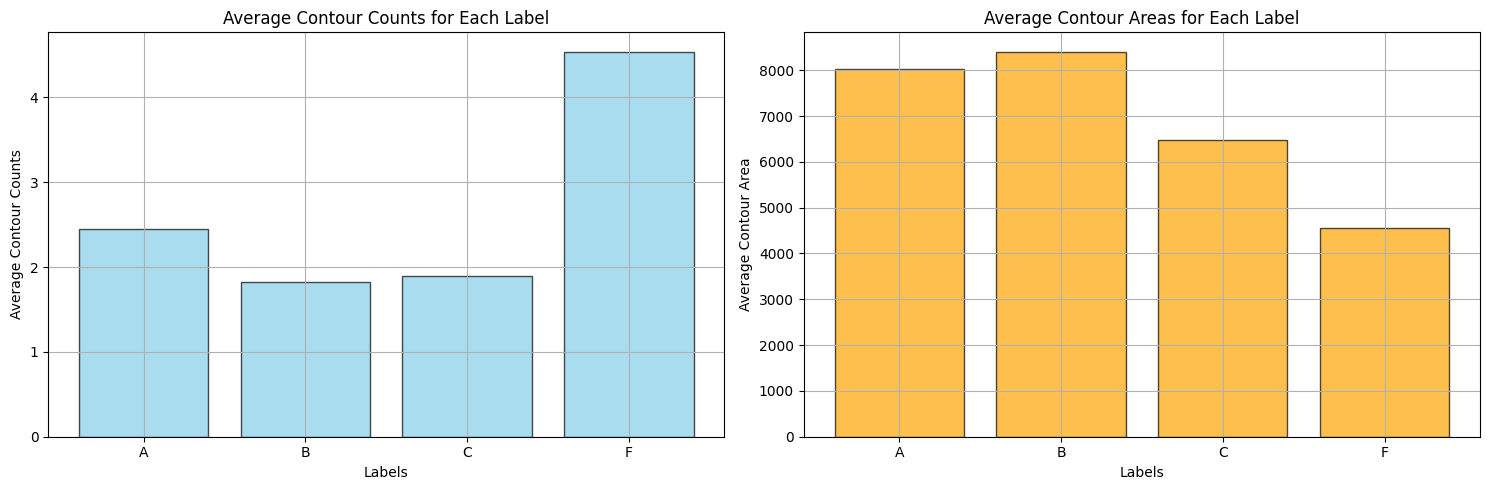

In [102]:
plot_histograms(avg_contour_counts, avg_contour_areas, labels)
